In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
import xgboost as xgb
from xgboost import XGBClassifier
import torch

In [239]:
df = pd.read_csv("cardio_train.csv", delimiter=";")
df = df.drop(columns=['id'])

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


(None,
      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
 0  18393       2     168    62.0    110     80            1     1      0   
 1  20228       1     156    85.0    140     90            3     1      0   
 2  18857       1     165    64.0    130     70            3     1      0   
 3  17623       2     169    82.0    150    100            1     1      0   
 4  17474       1     156    56.0    100     60            1     1      0   
 
    alco  active  cardio  
 0     0       1       0  
 1     0       1       1  
 2     0       0       1  
 3     0       1       1  
 4     0       0       0  )

In [241]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

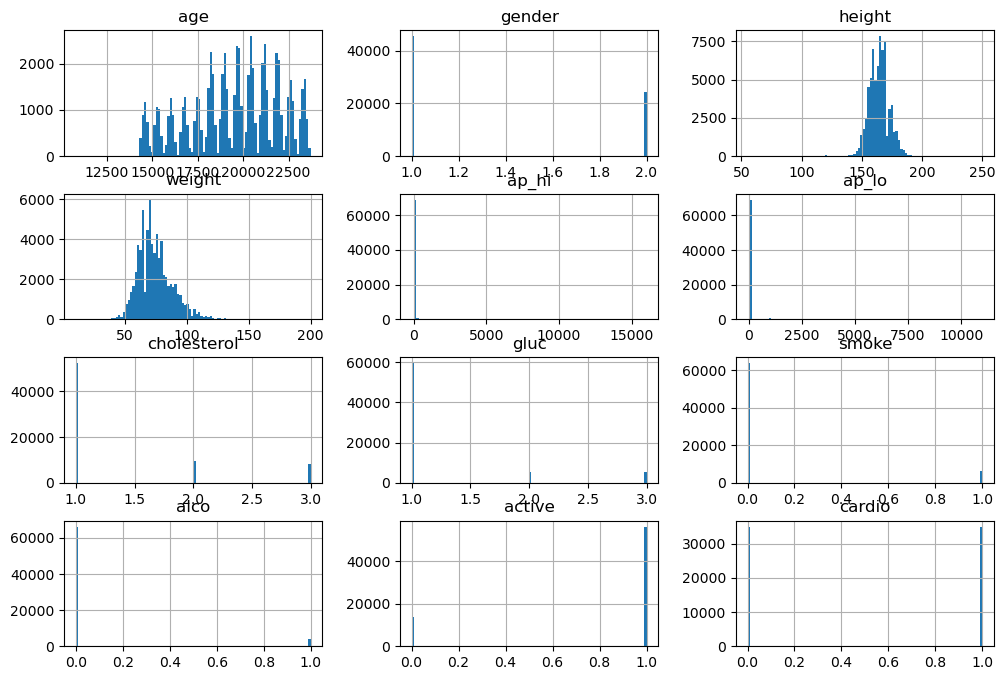

In [243]:
df.hist(bins=100, figsize=(12, 8))
plt.show()

In [244]:
df = df[
    (df.ap_hi.between(70, 200)) &
    (df.ap_lo.between(40, 150)) &
    (df.ap_hi > df.ap_lo)
]

In [247]:
df["gender"] = df["gender"] - 1

In [249]:
df["age"] = df["age"] / 365.25

In [251]:
min_height = df["height"].min()
max_height = df["height"].max()

print(f"Minimum height: {min_height}")
print(f"Maximum height: {max_height}")

Minimum height: 55
Maximum height: 250


In [253]:
df = df[df["height"] >= 80] 

In [255]:
min_weight = df["weight"].min()
max_weight = df["weight"].max()

print(f"Minimum weigth: {min_weight}")
print(f"Maximum weigth: {max_weight}")

Minimum weigth: 11.0
Maximum weigth: 200.0


In [257]:
df = df[df["weight"] >= 40] 

In [259]:
height_m = df['height'] / 100
df['BMI'] = df['weight'] / (height_m ** 2)
df['BMI'] = df['BMI'].round(2)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 68546 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68546 non-null  float64
 1   gender       68546 non-null  int64  
 2   height       68546 non-null  int64  
 3   weight       68546 non-null  float64
 4   ap_hi        68546 non-null  int64  
 5   ap_lo        68546 non-null  int64  
 6   cholesterol  68546 non-null  int64  
 7   gluc         68546 non-null  int64  
 8   smoke        68546 non-null  int64  
 9   alco         68546 non-null  int64  
 10  active       68546 non-null  int64  
 11  cardio       68546 non-null  int64  
 12  BMI          68546 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 7.3 MB


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000,68546.000000
mean,53.288437,0.348642,164.396551,74.137301,126.611181,81.280731,1.364514,1.225600,0.087985,0.053351,0.803358,0.494617,27.487797
std,6.758160,0.476544,8.003252,14.285852,16.492821,9.368653,0.678830,0.571496,0.283275,0.224734,0.397462,0.499975,5.523511
min,29.563313,0.000000,80.000000,40.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.520000
25%,48.339493,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.880000
50%,53.935661,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.350000
75%,58.381930,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.120000
max,64.922656,1.000000,250.000000,200.000000,200.000000,150.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,278.120000


In [261]:
X = df.drop(columns=['cardio'])
y = df['cardio']

In [263]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size=.2, random_state=42)

In [265]:
def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=None):
    assert train_size + val_size + test_size == 1

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [267]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42)

In [269]:
lower_hi = X_train["ap_hi"].quantile(0.005)
upper_hi = X_train["ap_hi"].quantile(0.995)
lower_lo = X_train["ap_lo"].quantile(0.005)
upper_lo = X_train["ap_lo"].quantile(0.995)

mask = (
    (X_train["ap_hi"] >= lower_hi) &
    (X_train["ap_hi"] <= upper_hi) &
    (X_train["ap_lo"] >= lower_lo) &
    (X_train["ap_lo"] <= upper_lo) &
    (X_train["ap_hi"] >  X_train["ap_lo"])
)

X_train = X_train.loc[mask]
y_train = y_train.loc[mask]

print(X_train.shape, y_train.shape)

(54390, 12) (54390,)


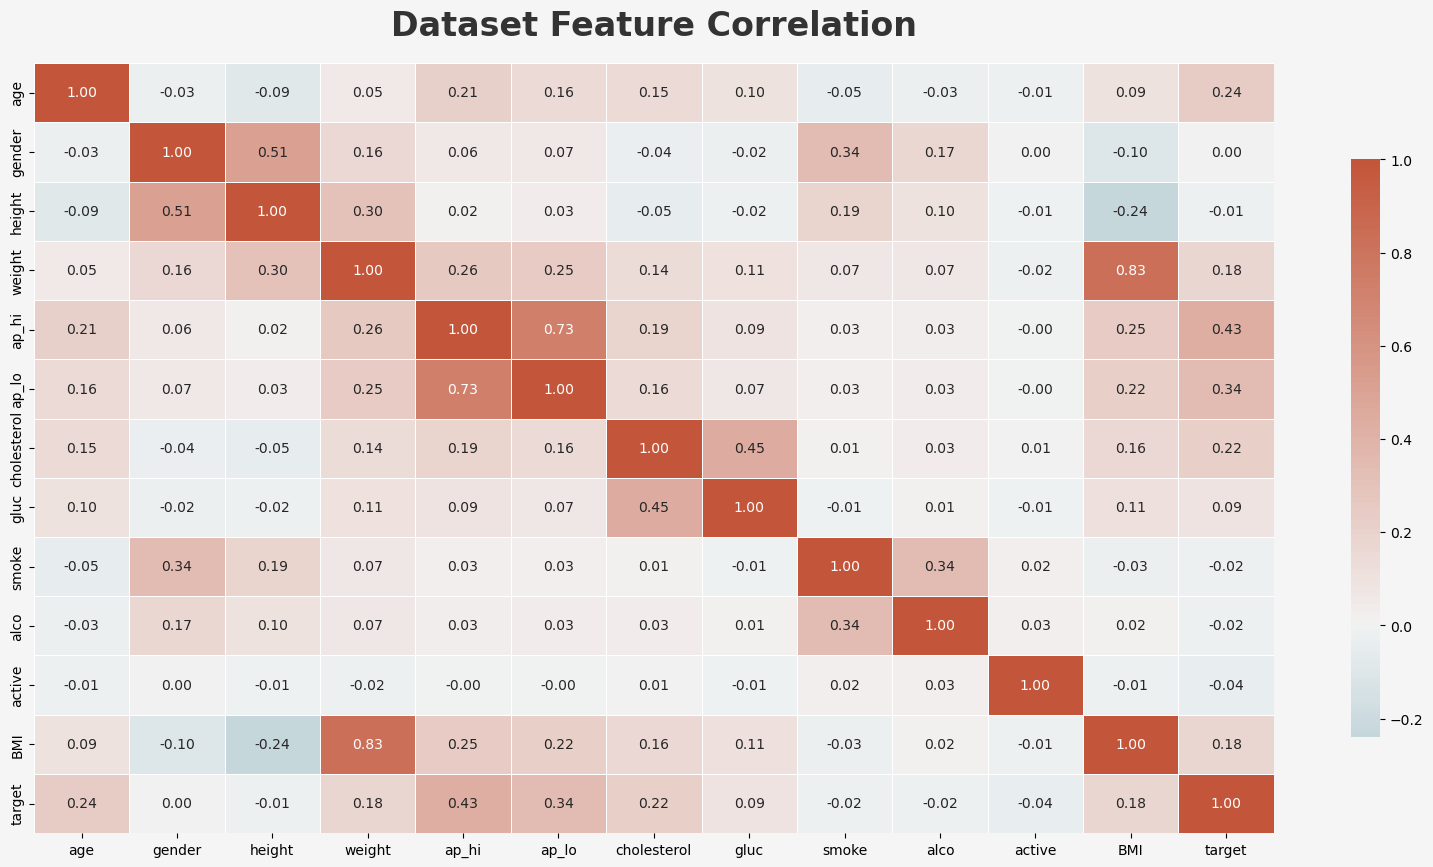

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,target
age,1.000000,-0.025666,-0.085063,0.054293,0.214078,0.156890,0.153537,0.095640,-0.047844,-0.028220,-0.012687,0.094874,0.240187
gender,-0.025666,1.000000,0.507310,0.158058,0.060842,0.065640,-0.035385,-0.022386,0.337723,0.170568,0.003874,-0.103577,0.004672
height,-0.085063,0.507310,1.000000,0.298361,0.016054,0.034532,-0.053041,-0.021305,0.192021,0.097579,-0.011621,-0.239295,-0.013650
weight,0.054293,0.158058,0.298361,1.000000,0.263123,0.245965,0.139472,0.107425,0.069061,0.067518,-0.019681,0.826968,0.175793
ap_hi,0.214078,0.060842,0.016054,0.263123,1.000000,0.726001,0.188203,0.090507,0.025798,0.029730,-0.000358,0.247008,0.431286
ap_lo,0.156890,0.065640,0.034532,0.245965,0.726001,1.000000,0.155723,0.070474,0.025924,0.034283,-0.000258,0.221699,0.339646
cholesterol,0.153537,-0.035385,-0.053041,0.139472,0.188203,0.155723,1.000000,0.450918,0.010608,0.033497,0.006774,0.160353,0.221539
gluc,0.095640,-0.022386,-0.021305,0.107425,0.090507,0.070474,0.450918,1.000000,-0.007931,0.009297,-0.009259,0.114538,0.090518
smoke,-0.047844,0.337723,0.192021,0.069061,0.025798,0.025924,0.010608,-0.007931,1.000000,0.337964,0.024471,-0.029414,-0.019856
alco,-0.028220,0.170568,0.097579,0.067518,0.029730,0.034283,0.033497,0.009297,0.337964,1.000000,0.025417,0.015095,-0.016162


In [271]:
import seaborn as sns

train_data = X_train.copy()
train_data['target'] = y_train

corr_matrix = train_data.corr()

plt.figure(figsize=(20, 10), facecolor='#f5f5f5')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            annot=True, 
            fmt=".2f", 
            cmap=cmap, 
            center=0,
            linewidths=.5, 
            cbar_kws={"shrink": .75})

plt.title("Dataset Feature Correlation", fontsize=24, fontweight='bold', pad=20, color='#333333')

plt.show()

corr_matrix

In [272]:
features = ['age', 'ap_hi', 'ap_lo', 'gender', 'cholesterol', 'BMI', 'gluc', 'smoke', 'alco', 'active']

X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]
X_test_and_val = X_test_and_val[features]

In [275]:
from sklearn.preprocessing import StandardScaler
import joblib
import os

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[features] = scaler.fit_transform(X_train[features])

X_test_scaled = X_test.copy()
X_test_scaled[features] = scaler.transform(X_test[features])

X_val_scaled = X_val.copy()
X_val_scaled[features] = scaler.transform(X_val[features])

X_test_and_val_scaled = X_test_and_val.copy()
X_test_and_val_scaled[features] = scaler.transform(X_test_and_val_scaled[features])

joblib.dump(scaler, 'feature_scaler_new.pkl')

loaded_scaler = joblib.load('feature_scaler_new.pkl')

print("Loaded scaler mean:", loaded_scaler.mean_)
print("Loaded scaler variance:", loaded_scaler.var_)

original_scaled = loaded_scaler.transform(X_train[features])
loaded_scaled = loaded_scaler.transform(X_train[features])

if np.allclose(original_scaled, loaded_scaled):
    print("Verification successful: The scaler works as expected.")
else:
    print("Verification failed: The scaler may not be consistent.")

Loaded scaler mean: [5.32870797e+01 1.26372605e+02 8.11967457e+01 3.48446406e-01
 1.36339401e+00 2.74813208e+01 1.22638353e+00 8.72035301e-02
 5.31163817e-02 8.02555617e-01]
Loaded scaler variance: [4.57454962e+01 2.50674881e+02 8.05707230e+01 2.27031508e-01
 4.60130860e-01 3.05328423e+01 3.28323950e-01 7.95990744e-02
 5.02950317e-02 1.58460099e-01]
Verification successful: The scaler works as expected.


In [277]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54390 entries, 67992 to 16130
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          54390 non-null  float64
 1   ap_hi        54390 non-null  float64
 2   ap_lo        54390 non-null  float64
 3   gender       54390 non-null  float64
 4   cholesterol  54390 non-null  float64
 5   BMI          54390 non-null  float64
 6   gluc         54390 non-null  float64
 7   smoke        54390 non-null  float64
 8   alco         54390 non-null  float64
 9   active       54390 non-null  float64
dtypes: float64(10)
memory usage: 4.6 MB


In [279]:
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, log_loss, confusion_matrix
)
from sklearn.calibration import calibration_curve

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.sum(mask) > 0:
            avg_confidence = np.mean(y_prob[mask])
            avg_accuracy = np.mean(y_true[mask])
            ece += np.abs(avg_confidence - avg_accuracy) * np.sum(mask) / len(y_prob)
    return ece

def evaluate_model_performance(y_true, y_pred, y_pred_prob, show_plots=True):
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    brier = brier_score_loss(y_true, y_pred_prob)
    logloss = log_loss(y_true, y_pred_prob)
    ece = expected_calibration_error(y_true, y_pred_prob)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Brier Score: {brier:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    if show_plots:
        frac_pos, mean_pred_val = calibration_curve(y_true, y_pred_prob, n_bins=10)
        plt.figure(figsize=(6, 5))
        plt.plot(mean_pred_val, frac_pos, marker='o', label="Calibration Curve")
        plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title("Calibration Curve")
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
from sklearn.metrics import make_scorer

random_forest_full_set = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 120, 150],
    'max_depth': [5, 8, 10, 12],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['log_loss']
}

brier_scorer = make_scorer(brier_score_loss, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=random_forest_full_set,
    param_grid=param_grid,
    scoring=brier_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_and_val_scaled)
y_pred_prob = best_rf.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


ROC AUC: 0.8497
Brier Score: 0.1599
Log Loss: 0.4883
Expected Calibration Error (ECE): 0.0476

Confusion Matrix:
[[22526  4969]
 [ 7610 19285]]


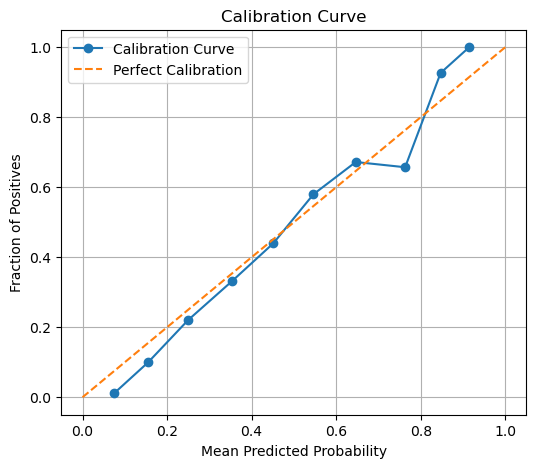

In [116]:
y_pred_train = best_rf.predict(X_train_scaled)
y_pred_prob_train = best_rf.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred_train, y_pred_prob_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


C:\Users\ediiz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.09, 'max_depth': 4, 'n_estimators': 90}
ROC AUC: 0.8025
Brier Score: 0.1802
Log Loss: 0.5397
Expected Calibration Error (ECE): 0.0101

Confusion Matrix:
[[5451 1557]
 [2130 4572]]


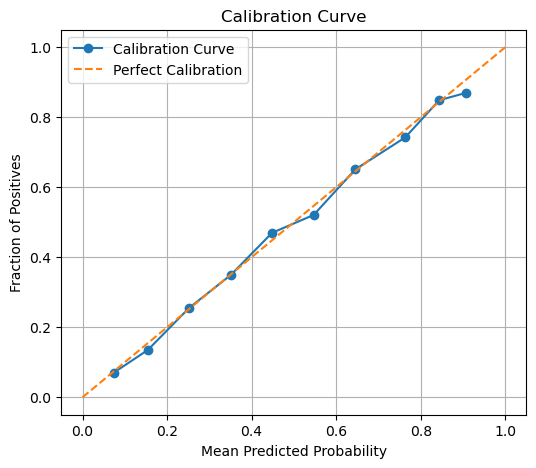

In [95]:
xgb_model_full_set = XGBClassifier(
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators': [80, 85, 90, 95, 100, 105]
}

grid_search = GridSearchCV(
    estimator=xgb_model_full_set,
    param_grid=param_grid,
    scoring='neg_brier_score',
    cv=4,
    n_jobs=2,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_and_val_scaled)
y_pred_prob = best_xgb.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

ROC AUC: 0.8076
Brier Score: 0.1780
Log Loss: 0.5344
Expected Calibration Error (ECE): 0.0076

Confusion Matrix:
[[    0 27495]
 [    0 26895]]


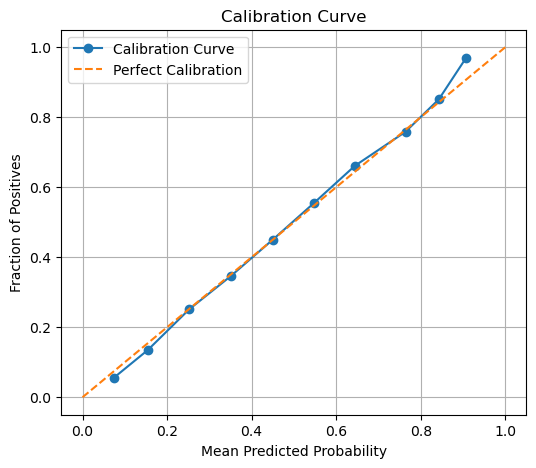

In [101]:
y_pred = best_xgb.predict(X_train)
y_pred_prob_train = best_xgb.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred, y_pred_prob_train)

Best Parameters: {'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}
ROC AUC: 0.7827
Brier Score: 0.1895
Log Loss: 0.5739
Expected Calibration Error (ECE): 0.0223

Confusion Matrix:
[[2691  828]
 [1090 2246]]


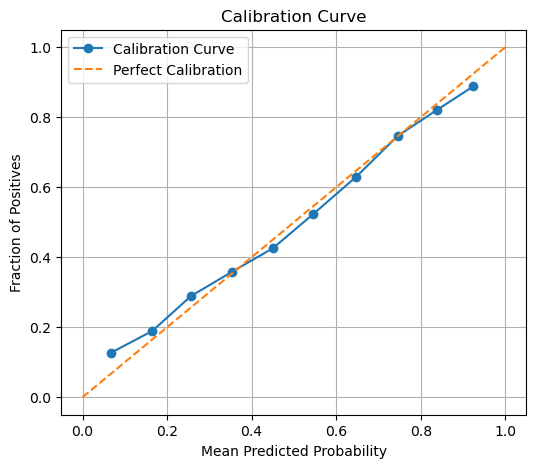

Best number of neighbors: 31


In [105]:
model_name_knn = 'KNeighborsClassifier_GridSearch'

knn_model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': list(range(3, 32, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best Parameters:", grid_search_knn.best_params_)
y_pred = best_knn.predict(X_test_scaled)
y_pred_prob = best_knn.predict_proba(X_test_scaled)[:, 1]

evaluate_model_performance(y_test, y_pred, y_pred_prob)

print(f"Best number of neighbors: {grid_search_knn.best_params_['n_neighbors']}")

ROC AUC: 0.8152
Brier Score: 0.1750
Log Loss: 0.5249
Expected Calibration Error (ECE): 0.0072

Confusion Matrix:
[[21474  6021]
 [ 7988 18907]]


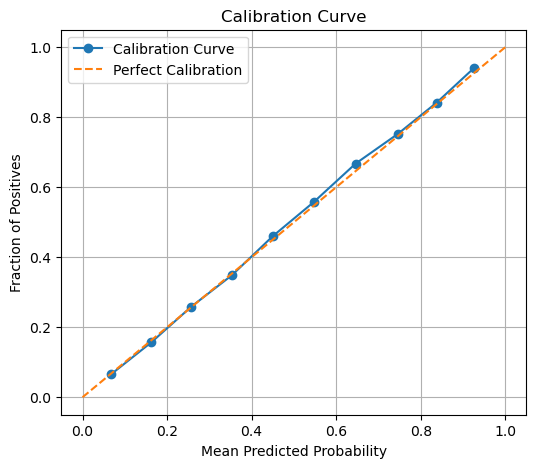

In [107]:
y_pred_train = best_knn.predict(X_train_scaled)
y_pred_prob_train = best_knn.predict_proba(X_train_scaled)[:, 1]
evaluate_model_performance(y_train, y_pred_train, y_pred_prob_train)

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7}
ROC AUC: 0.7945
Brier Score: 0.1831
Log Loss: 0.5789
Expected Calibration Error (ECE): 0.0074

Confusion Matrix:
[[5533 1475]
 [2252 4450]]


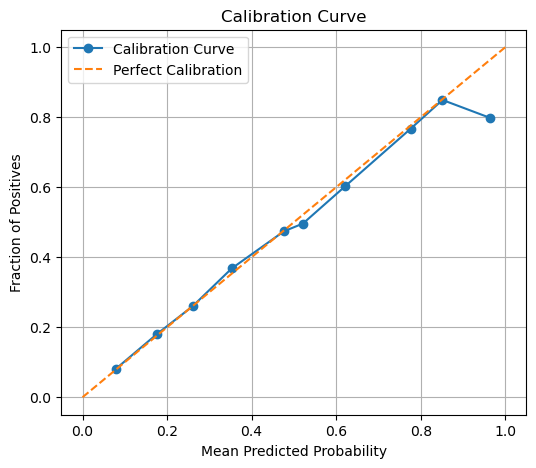

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7}


In [109]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15,],
    'min_samples_split': [2, 5, 7, 9],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_dt.fit(X_train_scaled, y_train)
best_tree = grid_search_dt.best_estimator_
print("Best Parameters:", grid_search_dt.best_params_)
y_pred = best_tree.predict(X_test_and_val_scaled)
y_pred_prob = best_tree.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

print("Best Decision Tree Params:", grid_search_dt.best_params_)

ROC AUC: 0.8016
Brier Score: 0.1797
Log Loss: 0.5385
Expected Calibration Error (ECE): 0.0000

Confusion Matrix:
[[21829  5666]
 [ 8741 18154]]


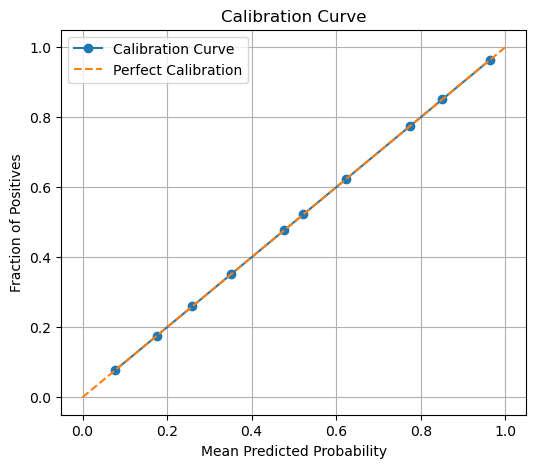

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7}


In [111]:
y_pred_train = best_tree.predict(X_train_scaled)
y_pred_prob_train = best_tree.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred_train, y_pred_prob_train)

print("Best Decision Tree Params:", grid_search_dt.best_params_)

# Decision Tree likely overfitted

C:\Users\ediiz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.8013
Brier Score: 0.1806
Log Loss: 0.5409
Expected Calibration Error (ECE): 0.0097

Confusion Matrix:
[[5498 1510]
 [2178 4524]]


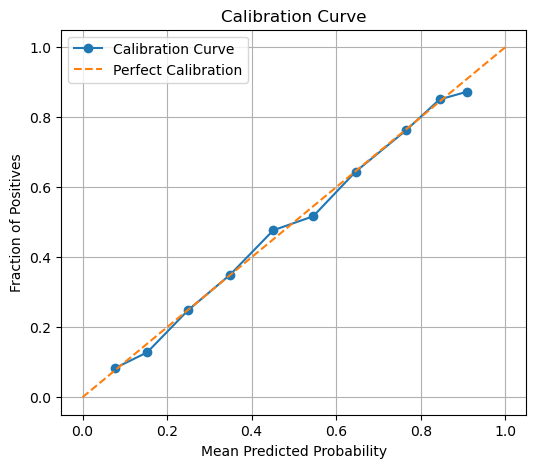

In [118]:
from sklearn.ensemble import VotingClassifier

ensemble_full_set = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('knn', best_knn),
        ('dt', best_tree)
    ],
    voting='soft'
)

ensemble_full_set.fit(X_train_scaled, y_train)

y_pred = ensemble_full_set.predict(X_test_and_val_scaled)
y_pred_prob = ensemble_full_set.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

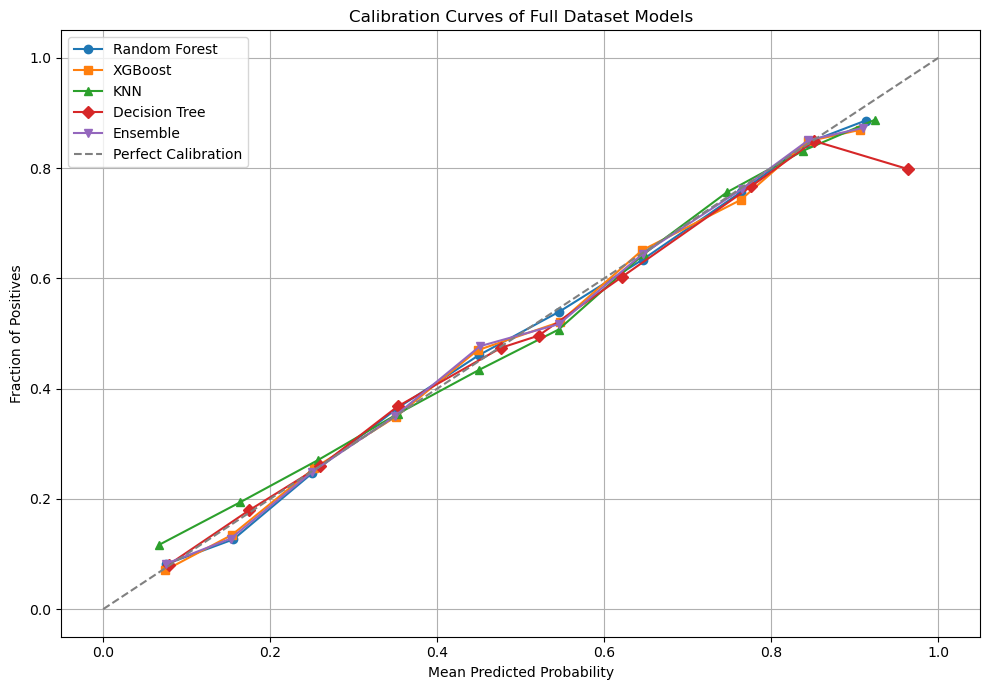

In [120]:
models = [
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb),
    ('KNN', best_knn),
    ('Decision Tree', best_tree),
    ('Ensemble', ensemble_full_set)
]

markers = ['o', 's', '^', 'D', 'v']

plt.figure(figsize=(10, 7))

for (name, model), marker in zip(models, markers):
    y_pred_prob = model.predict_proba(X_test_and_val_scaled)[:, 1]
    frac_pos, mean_pred_val = calibration_curve(y_test_and_val, y_pred_prob, n_bins=10)
    plt.plot(mean_pred_val, frac_pos, marker=marker, label=name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves of Full Dataset Models")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 60 candidates, totalling 300 fits
ROC AUC: 0.7997
Brier Score: 0.1813
Log Loss: 0.5430
Expected Calibration Error (ECE): 0.0138

Confusion Matrix:
[[5581 1427]
 [2234 4468]]


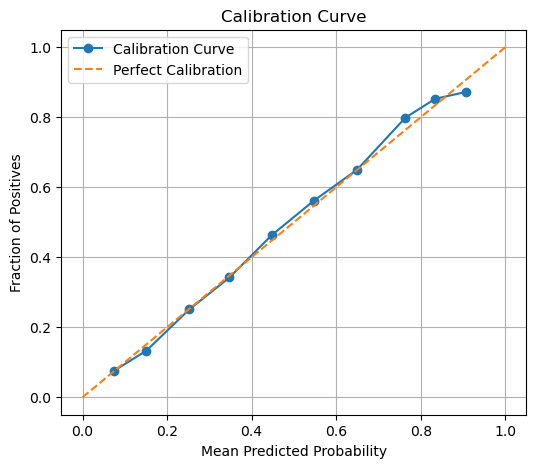

Best Refined MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32,), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_iter': 400, 'solver': 'adam'}


In [122]:
param_grid_mlp_refined = {
    'hidden_layer_sizes': [
        (16,),
        (32,),
        (64,),
        (32, 16),
        (64, 32),
    ],
    'activation': ['relu'],
    'alpha': [0.0001, 0.0005, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.005],
    'solver': ['adam'],
    'max_iter': [400]  
}

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)

grid_search_mlp_refined = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp_refined,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp_refined.fit(X_train_scaled, y_train)

best_mlp_refined = grid_search_mlp_refined.best_estimator_
y_pred = best_mlp_refined.predict(X_test_and_val_scaled)
y_pred_prob = best_mlp_refined.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

print("Best Refined MLP Params:", grid_search_mlp_refined.best_params_)


Accuracy: 0.7333
Precision: 0.7610
Recall: 0.6736
F1 Score: 0.7146
ROC AUC: 0.7997
PR AUC: 0.7838
Brier Score: 0.1815
Expected Calibration Error (ECE): 0.0081

Confusion Matrix:
[[5484 1440]
 [2222 4585]]


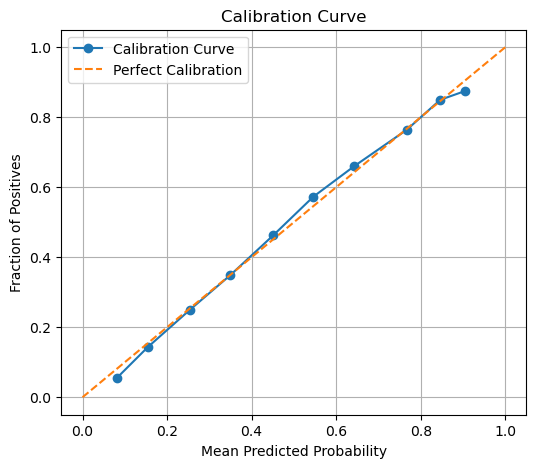

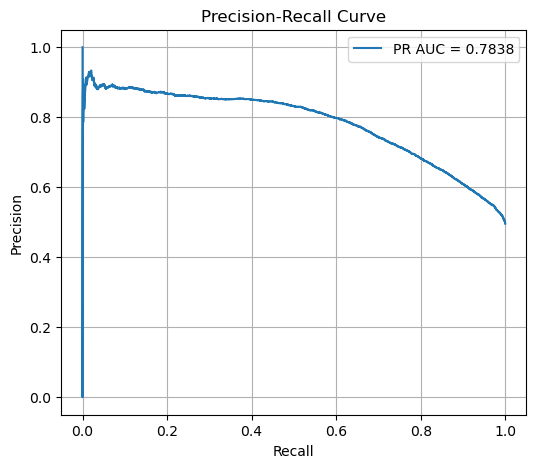

In [79]:
random_forest = RandomForestClassifier(criterion='log_loss', max_depth= 10,
                                       max_features='log2',n_estimators=100)
xg_boost = XGBClassifier(verbosity=1, n_estimators=95,
                            gamma= 0.3, max_depth=4, learning_rate=0.08,
                            reg_lambda=100, scale_pos_weight=1, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(32,),learning_rate='constant', activation='relu', alpha=0.001, learning_rate_init= 0.005,
                    max_iter=300, solver='adam', random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', random_forest), ('xgb', xg_boost), ('mlp', mlp)],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train_scaled, y_train)
y_pred = ensemble.predict(X_test_and_val_scaled)
y_pred_prob = ensemble.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

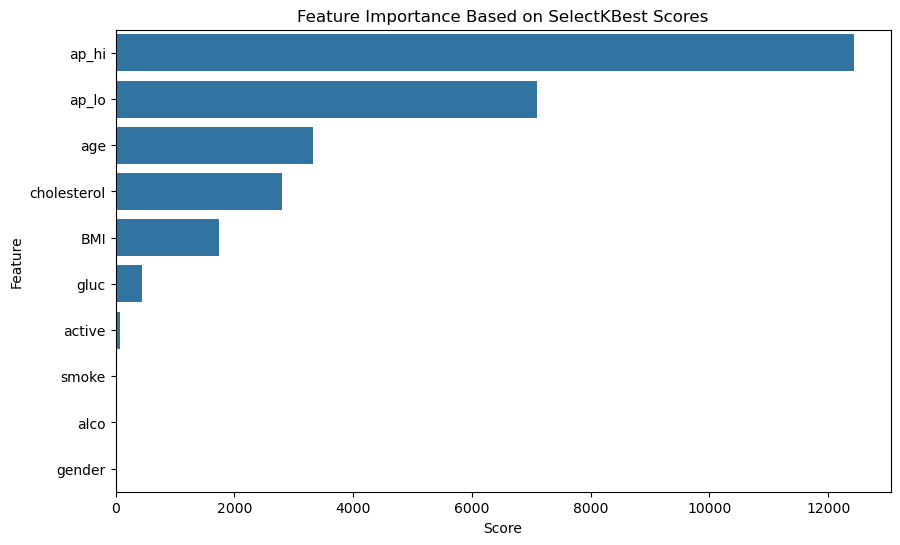

In [221]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k="all")
selector.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    "Feature": X_train.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Score", y="Feature", data=feature_scores)
plt.title("Feature Importance Based on SelectKBest Scores")
plt.show()

In [223]:
X_train = X_train[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]
X_test = X_test[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]
X_val = X_val[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]
X_test_and_val = X_test_and_val[["age", "ap_hi", "ap_lo", "cholesterol", "BMI"]]

In [225]:
print(X_train.columns)
print(X_test.columns)
print(X_val.columns)
print(X_test_and_val.columns)

print(X_train_scaled.columns)

Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI'], dtype='object')
Index(['age', 'ap_hi', 'ap_lo', 'gender', 'cholesterol', 'BMI', 'gluc',
       'smoke', 'alco', 'active'],
      dtype='object')


In [227]:
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI']

In [229]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = X_test.copy()
X_test_scaled = scaler.transform(X_test)

X_val_scaled = X_val.copy()
X_val_scaled = scaler.transform(X_val)

X_test_and_val_scaled = X_test_and_val.copy()
X_test_and_val_scaled = scaler.transform(X_test_and_val)

joblib.dump(scaler, 'feature_scaler_modif.pkl')

loaded_scaler = joblib.load('feature_scaler_modif.pkl')

print("Loaded scaler mean:", loaded_scaler.mean_)
print("Loaded scaler variance:", loaded_scaler.var_)

original_scaled = loaded_scaler.transform(X_train)
loaded_scaled = loaded_scaler.transform(X_train)

if np.allclose(original_scaled, loaded_scaled):
    print("Verification successful: The scaler works as expected.")
else:
    print("Verification failed: The scaler may not be consistent.")

Loaded scaler mean: [ 53.28707966 126.37260526  81.19674573   1.36339401  27.48132083]
Loaded scaler variance: [ 45.74549624 250.67488108  80.570723     0.46013086  30.53284234]
Verification successful: The scaler works as expected.


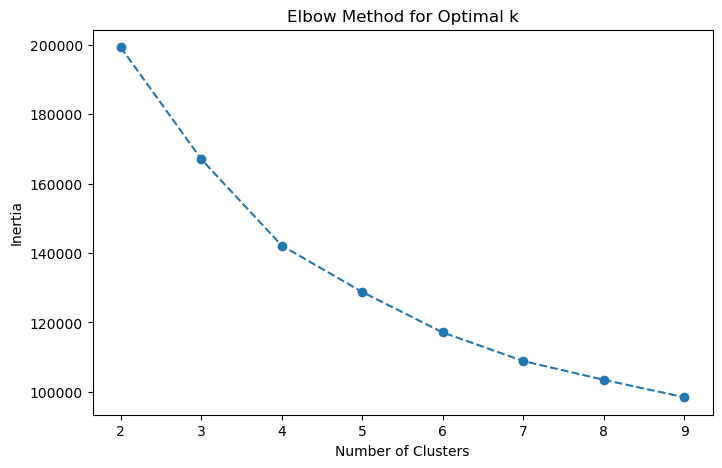

In [231]:
from sklearn.cluster import KMeans
import warnings\

inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [232]:
import pickle
from sklearn.preprocessing import MinMaxScaler

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_and_val_scaled = pd.DataFrame(X_test_and_val_scaled, columns=X_test_and_val.columns, index=X_test_and_val.index)

X_train_scaled.columns = X_train_scaled.columns.astype(str)
X_test_scaled.columns = X_test_scaled.columns.astype(str)
X_val_scaled.columns = X_val_scaled.columns.astype(str)
X_test_and_val_scaled.columns = X_test_and_val_scaled.columns.astype(str)

k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, init="k-means++", random_state=42, n_init=10)
X_train_scaled["Cluster"] = kmeans_final.fit_predict(X_train_scaled)

X_test_scaled["Cluster"] = kmeans_final.predict(X_test_scaled)
X_val_scaled["Cluster"] = kmeans_final.predict(X_val_scaled)
X_test_and_val_scaled["Cluster"] = kmeans_final.predict(X_test_and_val_scaled)

X_train["Cluster"] = X_train_scaled["Cluster"]
X_test["Cluster"] = X_test_scaled["Cluster"]
X_val["Cluster"] = X_val_scaled["Cluster"]
X_test_and_val["Cluster"] = X_test_and_val_scaled["Cluster"]

cluster_scaler = MinMaxScaler()
X_train_scaled["Cluster"] = cluster_scaler.fit_transform(X_train_scaled[["Cluster"]])
X_test_scaled["Cluster"] = cluster_scaler.transform(X_test_scaled[["Cluster"]])
X_val_scaled["Cluster"] = cluster_scaler.transform(X_val_scaled[["Cluster"]])
X_test_and_val_scaled["Cluster"] = cluster_scaler.transform(X_test_and_val_scaled[["Cluster"]])

with open("cluster_scaler_modif.pkl", "wb") as scaler_file:
    pickle.dump(cluster_scaler, scaler_file)

with open("kmeans_model_modif.pkl", "wb") as kmeans_file:
    pickle.dump(kmeans_final, kmeans_file)

print("Train Cluster Distribution:\n", X_train_scaled["Cluster"].value_counts())


Train Cluster Distribution:
 Cluster
1.0    32085
0.0    13574
0.5     8731
Name: count, dtype: int64


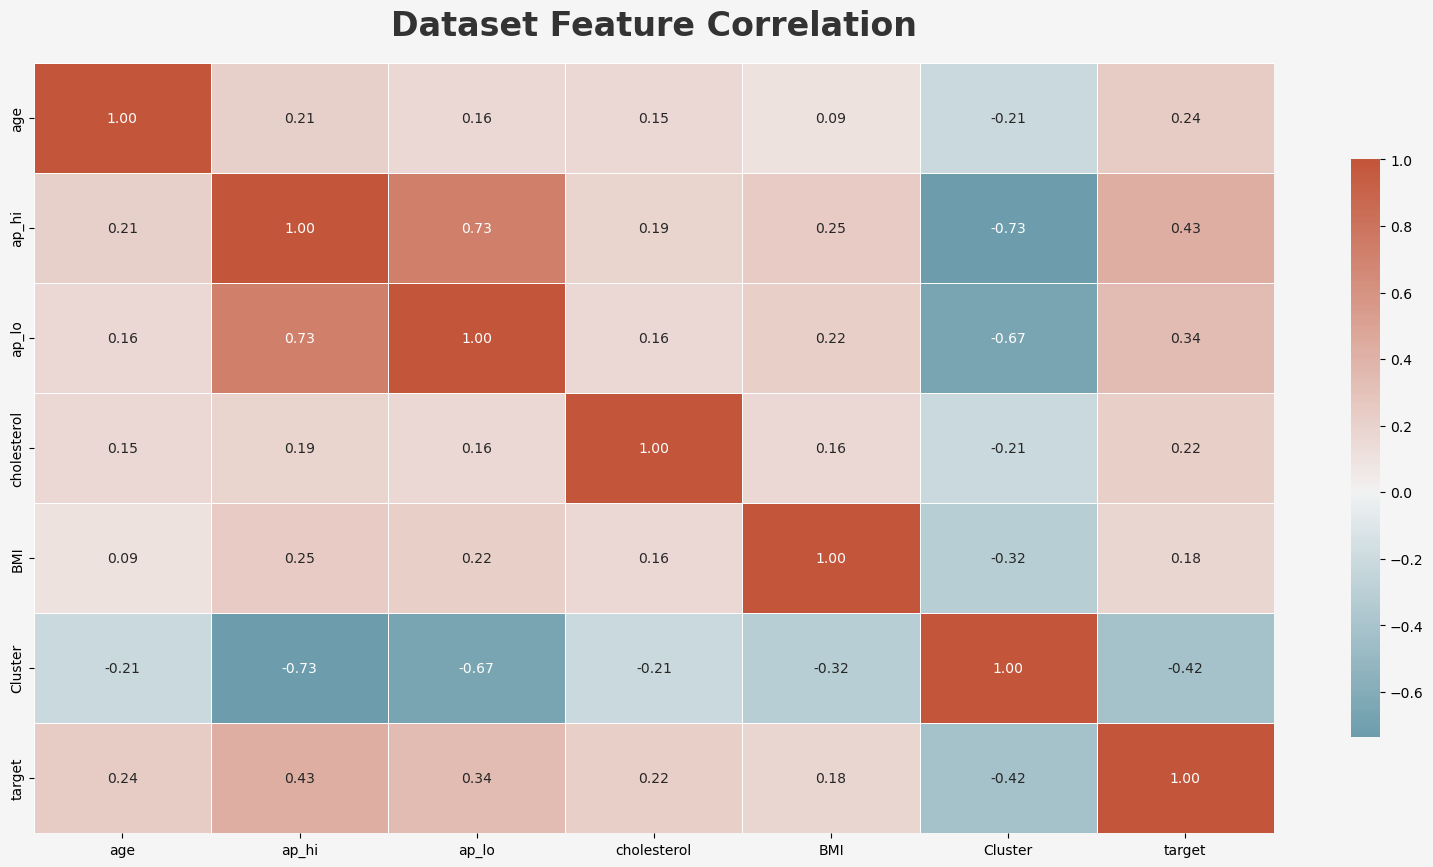

,age,ap_hi,ap_lo,cholesterol,BMI,Cluster,target
age,1.000000,0.214078,0.156890,0.153537,0.094874,-0.211857,0.240187
ap_hi,0.214078,1.000000,0.726001,0.188203,0.247008,-0.734921,0.431286
ap_lo,0.156890,0.726001,1.000000,0.155723,0.221699,-0.665646,0.339646
cholesterol,0.153537,0.188203,0.155723,1.000000,0.160353,-0.208405,0.221539
BMI,0.094874,0.247008,0.221699,0.160353,1.000000,-0.318848,0.176535
Cluster,-0.211857,-0.734921,-0.665646,-0.208405,-0.318848,1.000000,-0.424396
target,0.240187,0.431286,0.339646,0.221539,0.176535,-0.424396,1.000000


In [130]:
train_data = X_train_scaled.copy()
train_data['target'] = y_train

corr_matrix = train_data.corr()

plt.figure(figsize=(20, 10), facecolor='#f5f5f5')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            annot=True, 
            fmt=".2f", 
            cmap=cmap, 
            center=0,
            linewidths=.5, 
            cbar_kws={"shrink": .75})

plt.title("Dataset Feature Correlation", fontsize=24, fontweight='bold', pad=20, color='#333333')

plt.show()

corr_matrix

Best Parameters: {'n_neighbors': 31, 'p': 2, 'weights': 'uniform'}
ROC AUC: 0.7854
Brier Score: 0.1880
Log Loss: 0.5996
Expected Calibration Error (ECE): 0.0255

Confusion Matrix:
[[2712  807]
 [1081 2255]]


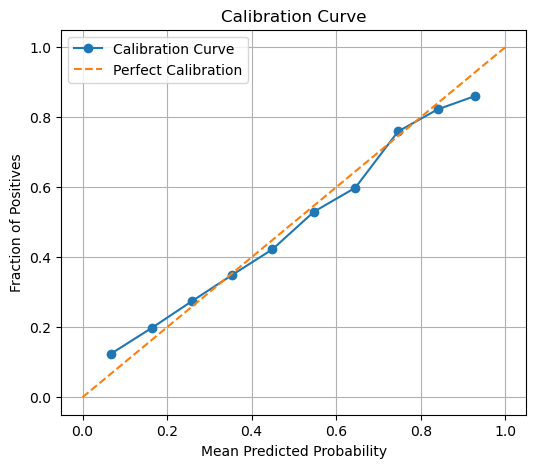

Best number of neighbors: 31


In [131]:
model_name_knn = 'KNeighborsClassifier_GridSearch'

knn_model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': list(range(3, 32, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

best_knn = grid_search_knn.best_estimator_
print("Best Parameters:", grid_search_knn.best_params_)
y_pred = best_knn.predict(X_test_scaled)
y_pred_prob = best_knn.predict_proba(X_test_scaled)[:, 1]

evaluate_model_performance(y_test, y_pred, y_pred_prob)

print(f"Best number of neighbors: {grid_search_knn.best_params_['n_neighbors']}")

ROC AUC: 0.8132
Brier Score: 0.1758
Log Loss: 0.5266
Expected Calibration Error (ECE): 0.0056

Confusion Matrix:
[[21377  6118]
 [ 8057 18838]]


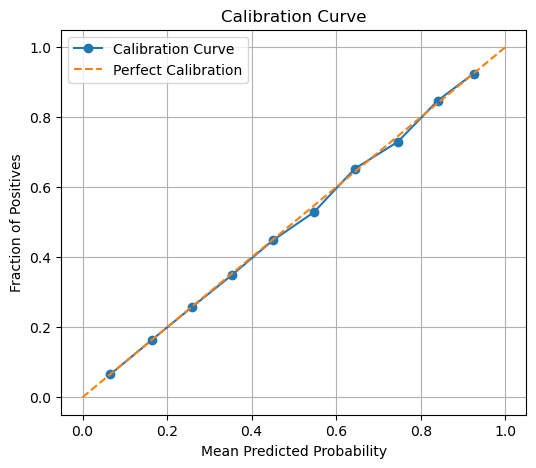

In [132]:
y_pred_train = best_knn.predict(X_train_scaled)
y_pred_prob_train = best_knn.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred_train, y_pred_prob_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best ROC AUC Score: -0.18244572065398657
Best Parameters: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 80}
ROC AUC: 0.7989
Brier Score: 0.1816
Log Loss: 0.5431
Expected Calibration Error (ECE): 0.0080

Confusion Matrix:
[[5441 1567]
 [2130 4572]]


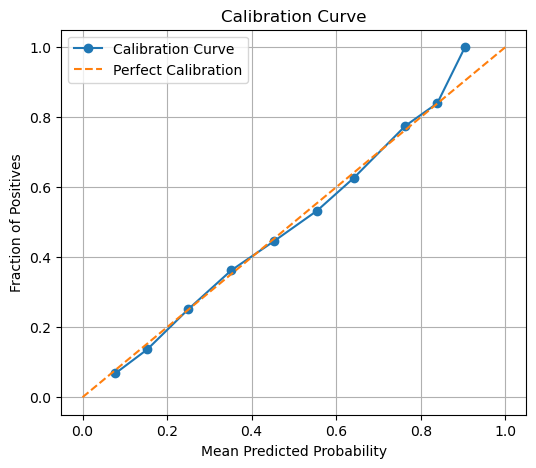

In [135]:
xgb_model = XGBClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators': [80, 85, 90, 95, 100, 105]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_brier_score',
    cv=5,
    verbose=1,
    n_jobs=2 
)

grid_search.fit(X_train_scaled, y_train)

print("Best ROC AUC Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

best_xgb_model_reduced = grid_search.best_estimator_

y_pred = best_xgb_model_reduced.predict(X_test_and_val_scaled)
y_pred_prob = best_xgb_model_reduced.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

ROC AUC: 0.7993
Brier Score: 0.1815
Log Loss: 0.5427
Expected Calibration Error (ECE): 0.0054

Confusion Matrix:
[[5468 1540]
 [2147 4555]]


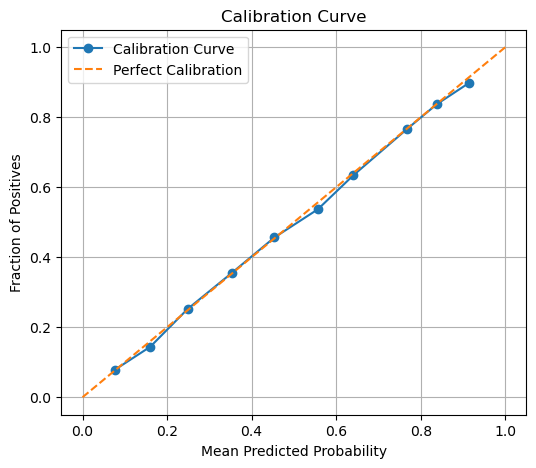

ROC AUC: 0.8031
Brier Score: 0.1800
Log Loss: 0.5389
Expected Calibration Error (ECE): 0.0056

Confusion Matrix:
[[21473  6022]
 [ 8371 18524]]


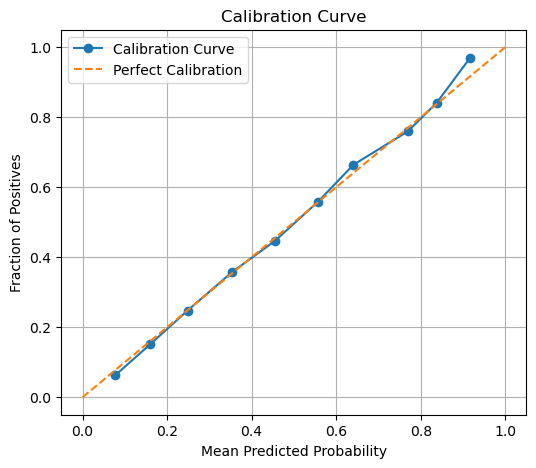

In [137]:
from joblib import dump, load
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgb = CalibratedClassifierCV(best_xgb_model_reduced, method='isotonic', cv=4)
calibrated_xgb.fit(X_train_scaled, y_train)

y_train_prob_calibrated = calibrated_xgb.predict_proba(X_train_scaled)[:, 1]
y_train_calibrated = calibrated_xgb.predict(X_train_scaled)

y_pred_prob_calibrated = calibrated_xgb.predict_proba(X_test_and_val_scaled)[:, 1]
y_pred_calibrated = calibrated_xgb.predict(X_test_and_val_scaled)

dump(calibrated_xgb, "xgb_calibrated.joblib")
calibrated_xgb = load("xgb_calibrated.joblib")

evaluate_model_performance(y_test_and_val, y_pred_calibrated, y_pred_prob_calibrated)
evaluate_model_performance(y_train, y_train_calibrated, y_train_prob_calibrated)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 150}
ROC AUC: 0.7983
Brier Score: 0.1821
Log Loss: 0.5444
Expected Calibration Error (ECE): 0.0110

Confusion Matrix:
[[5556 1452]
 [2255 4447]]


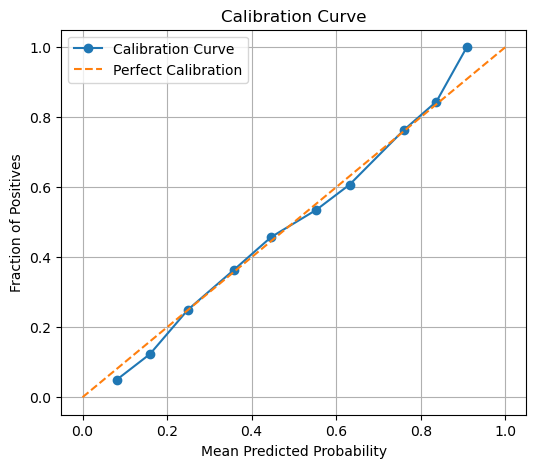

ROC AUC: 0.8089
Brier Score: 0.1782
Log Loss: 0.5350
Expected Calibration Error (ECE): 0.0151

Confusion Matrix:
[[21939  5556]
 [ 8654 18241]]


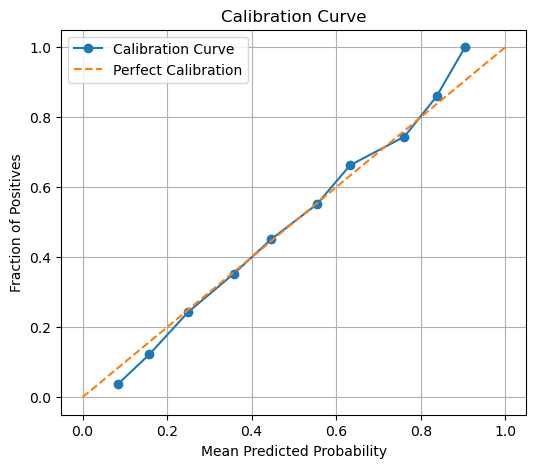

In [143]:
random_forest_full_set = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 120, 150],
    'max_depth': [5, 8, 10, 12],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['log_loss']
}

brier_scorer = make_scorer(brier_score_loss, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=random_forest_full_set,
    param_grid=param_grid,
    scoring=brier_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_and_val_scaled)
y_pred_prob = best_rf.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

y_pred_train = best_rf.predict(X_train_scaled)
y_pred_prob_train = best_rf.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred_train, y_pred_prob_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 26895, number of negative: 27495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 54390, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494484 -> initscore=-0.022064
[LightGBM] [Info] Start training from score -0.022064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

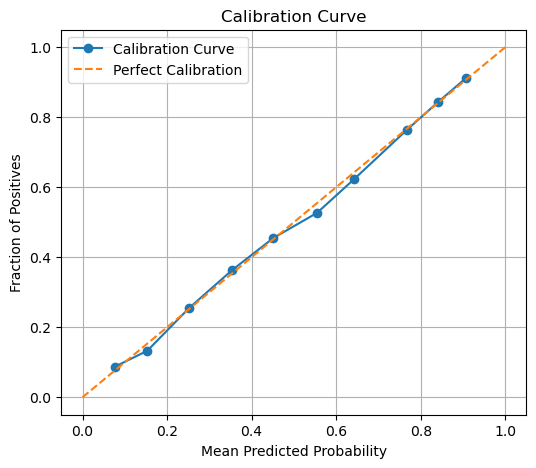

ROC AUC: 0.8041
Brier Score: 0.1797
Log Loss: 0.5383
Expected Calibration Error (ECE): 0.0066

Confusion Matrix:
[[21380  6115]
 [ 8233 18662]]


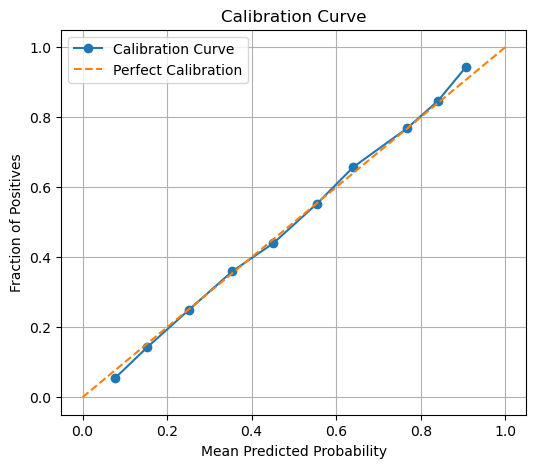

In [147]:
from lightgbm import LGBMClassifier

lgbm_classifier = LGBMClassifier()

param_grid_lgbm = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.07, 0.08, 0.09],
    'n_estimators':  [95, 100, 105]
}

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_classifier,
    param_grid=param_grid_lgbm,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_lgbm.fit(X_train_scaled, y_train)

print("Best ROC AUC Score (LightGBM):", grid_search_lgbm.best_score_)
print("Best Parameters (LightGBM):", grid_search_lgbm.best_params_)

best_lgbm_model = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm_model.predict(X_test_and_val_scaled)
y_pred_prob_lgbm = best_lgbm_model.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred_lgbm, y_pred_prob_lgbm)

y_pred_lgbm_train = best_lgbm_model.predict(X_train_scaled)
y_pred_prob_lgbm_train = best_lgbm_model.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred_lgbm_train, y_pred_prob_lgbm_train)

[LightGBM] [Info] Number of positive: 21516, number of negative: 21996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 43512, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494484 -> initscore=-0.022064
[LightGBM] [Info] Start training from score -0.022064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

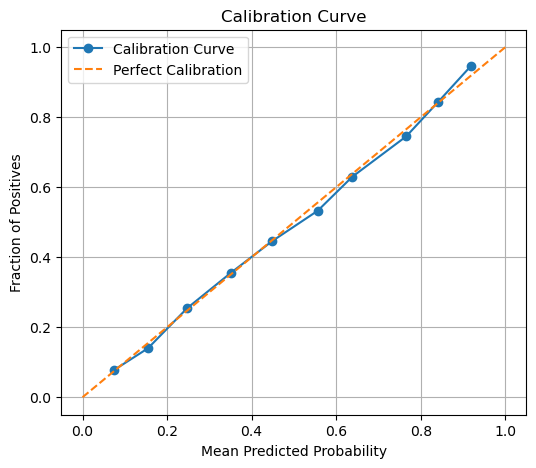

ROC AUC: 0.8048
Brier Score: 0.1794
Log Loss: 0.5374
Expected Calibration Error (ECE): 0.0056

Confusion Matrix:
[[21449  6046]
 [ 8298 18597]]


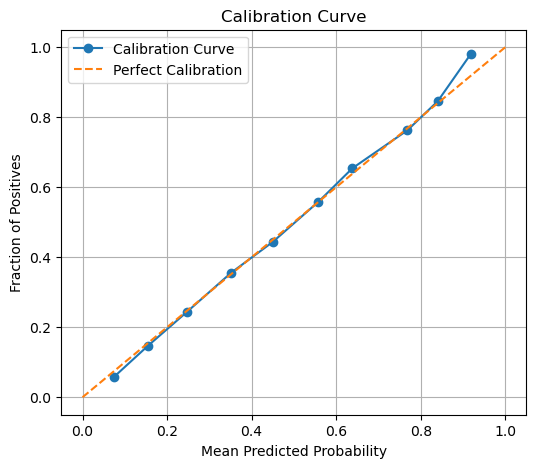

In [153]:
calibrated_lgbm = CalibratedClassifierCV(
    estimator=best_lgbm_model,
    method='isotonic',
    cv=5
)

calibrated_lgbm.fit(X_train_scaled, y_train)

dump(calibrated_lgbm, "lgbm_calibrated.joblib")

calibrated_lgbm = load("lgbm_calibrated.joblib")

y_pred_calibrated_lgbm = calibrated_lgbm.predict(X_test_and_val_scaled)
y_pred_prob_calibrated_lgbm = calibrated_lgbm.predict_proba(X_test_and_val_scaled)[:, 1]

y_pred_calibrated_lgbm_train = calibrated_lgbm.predict(X_train_scaled)
y_pred_prob_calibrated_lgbm_train = calibrated_lgbm.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred_calibrated_lgbm, y_pred_prob_calibrated_lgbm)
evaluate_model_performance(y_train, y_pred_calibrated_lgbm_train, y_pred_prob_calibrated_lgbm_train)

In [235]:
from pytorch_tabnet.tab_model import TabNetClassifier

X_train_np = X_train_scaled.values
y_train_np = y_train.values

X_val_np = X_val_scaled.values
y_val_np = y_val.values

X_test_np = X_test_scaled.values
y_test_np = y_test.values


tabnet_clf = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-3,
    n_shared=2,
    n_independent=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-3),
    mask_type='entmax',
    scheduler_params={"step_size": 20, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=42,
    verbose=1
)

tabnet_clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=["val"],
    eval_metric=["auc"],
    max_epochs=100,
    patience=20,
    batch_size=128,
    virtual_batch_size=64
)


y_test_pred = tabnet_clf.predict(X_test_np)
y_test_proba = tabnet_clf.predict_proba(X_test_np)[:, 1]

C:\Users\ediiz\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57607 | val_auc: 0.79976 |  0:00:10s
epoch 1  | loss: 0.55681 | val_auc: 0.80251 |  0:00:22s
epoch 2  | loss: 0.55448 | val_auc: 0.80311 |  0:00:33s
epoch 3  | loss: 0.55361 | val_auc: 0.80217 |  0:00:44s
epoch 4  | loss: 0.55256 | val_auc: 0.80075 |  0:00:55s
epoch 5  | loss: 0.55275 | val_auc: 0.80434 |  0:01:06s
epoch 6  | loss: 0.55291 | val_auc: 0.80154 |  0:01:18s
epoch 7  | loss: 0.55196 | val_auc: 0.79983 |  0:01:29s
epoch 8  | loss: 0.55144 | val_auc: 0.8038  |  0:01:40s
epoch 9  | loss: 0.55224 | val_auc: 0.80117 |  0:01:52s
epoch 10 | loss: 0.55238 | val_auc: 0.80388 |  0:02:03s
epoch 11 | loss: 0.55216 | val_auc: 0.80344 |  0:02:14s
epoch 12 | loss: 0.55096 | val_auc: 0.80331 |  0:02:27s
epoch 13 | loss: 0.55001 | val_auc: 0.80297 |  0:02:40s
epoch 14 | loss: 0.55005 | val_auc: 0.80381 |  0:02:54s
epoch 15 | loss: 0.54987 | val_auc: 0.80323 |  0:03:07s
epoch 16 | loss: 0.54952 | val_auc: 0.80309 |  0:03:21s
epoch 17 | loss: 0.54929 | val_auc: 0.80313 |  0

C:\Users\ediiz\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


ROC AUC: 0.7919
Brier Score: 0.1848
Log Loss: 0.5505
Expected Calibration Error (ECE): 0.0163

Confusion Matrix:
[[2769  750]
 [1121 2215]]


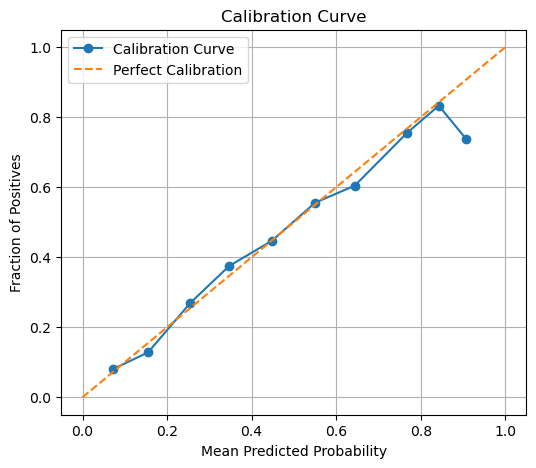

In [157]:
evaluate_model_performance(y_test_np, y_test_pred, y_test_proba)

ROC AUC: 0.7915
Brier Score: 0.1848
Log Loss: 0.5524
Expected Calibration Error (ECE): 0.0158

Confusion Matrix:
[[2811  708]
 [1161 2175]]


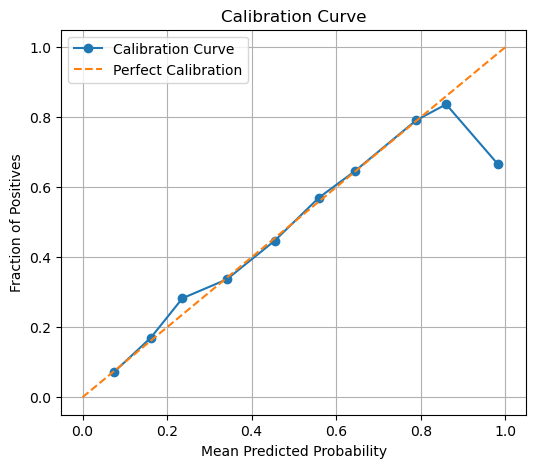

In [159]:
from sklearn.isotonic import IsotonicRegression

val_preds_proba = tabnet_clf.predict_proba(X_val_np)[:, 1]

iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(val_preds_proba, y_val_np)

test_preds_proba_raw = tabnet_clf.predict_proba(X_test_np)[:, 1]
test_preds_proba_calibrated = iso_reg.transform(test_preds_proba_raw)

test_preds_calibrated = (test_preds_proba_calibrated >= 0.5).astype(int)

evaluate_model_performance(y_test, test_preds_calibrated, test_preds_proba_calibrated)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
ROC AUC: 0.7985
Brier Score: 0.1817
Log Loss: 0.5433
Expected Calibration Error (ECE): 0.0119

Confusion Matrix:
[[5500 1508]
 [2200 4502]]


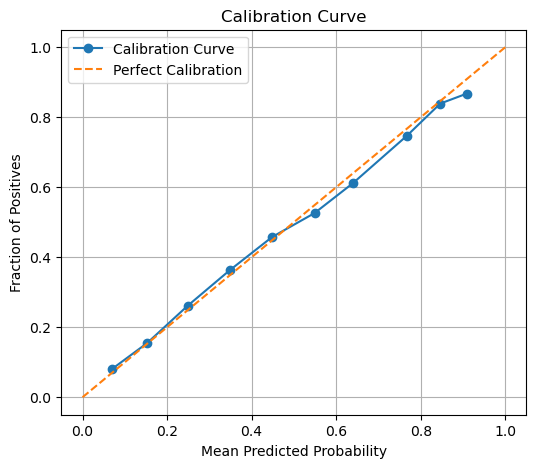

ROC AUC: 0.7991
Brier Score: 0.1815
Log Loss: 0.5434
Expected Calibration Error (ECE): 0.0087

Confusion Matrix:
[[21620  5875]
 [ 8591 18304]]


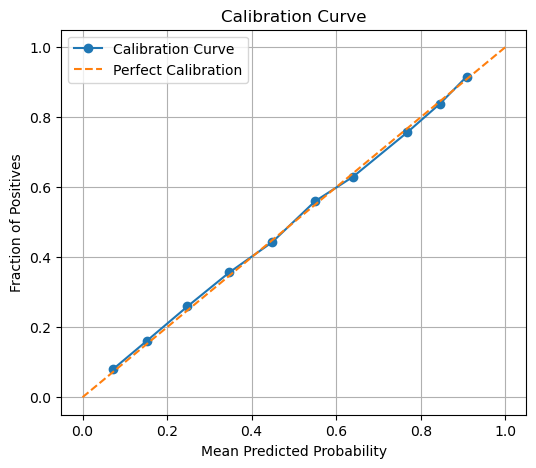

Best Refined MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (16, 8), 'learning_rate': 'constant', 'learning_rate_init': 0.003, 'max_iter': 150, 'solver': 'adam'}


In [163]:
param_grid_mlp_refined = {
    'hidden_layer_sizes': [
        (8,), (16,), (32,),
        (16, 8), (32, 16)
    ],
    'activation': ['relu'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.002, 0.003, 0.005],
    'solver': ['adam'],
    'max_iter': [150]
}

mlp = MLPClassifier(random_state=42)

grid_search_mlp_refined = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp_refined,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp_refined.fit(X_train_scaled, y_train)

best_mlp_refined = grid_search_mlp_refined.best_estimator_
y_pred = best_mlp_refined.predict(X_test_and_val_scaled)
y_pred_prob = best_mlp_refined.predict_proba(X_test_and_val_scaled)[:, 1]

evaluate_model_performance(y_test_and_val, y_pred, y_pred_prob)

y_pred_train = best_mlp_refined.predict(X_train_scaled)
y_pred_prob_train = best_mlp_refined.predict_proba(X_train_scaled)[:, 1]

evaluate_model_performance(y_train, y_pred_train, y_pred_prob_train)

print("Best Refined MLP Params:", grid_search_mlp_refined.best_params_)
